# 🌧️ ConvLSTM Precipitation Prediction + Elevation Classification via DecisionTree
**Dataset**: `ds_combined_downscaled_sample.nc`

Este notebook incluye:
- Predicción mensual con ConvLSTM
- Clasificación de elevación usando árbol de regresión (basado en precipitación)
- Validación cruzada espacial (GroupKFold)
- Exportación de modelo (`.h5`) y predicción (`.nc`)
- Mapas de predicción por mes

In [1]:
import numpy as np
import xarray as xr
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GroupKFold
import seaborn as sns
import os

In [2]:
# Cargar datos
ds = xr.open_dataset("/Users/riperez/Conda/anaconda3/doc/precipitation/output/ds_combined_downscaled_sample.nc")
precip = ds['downscaled_mean_precipitation'].values
dem = ds['elevation'].values

In [3]:
# Clasificación de elevación según precipitación media
precip_mean = np.nanmean(precip, axis=0)
flat_dem = dem.flatten().reshape(-1, 1)
flat_precip = precip_mean.flatten()
valid_mask = ~np.isnan(flat_dem[:, 0]) & ~np.isnan(flat_precip)
X = flat_dem[valid_mask]
y = flat_precip[valid_mask]
tree = DecisionTreeRegressor(max_leaf_nodes=4, min_samples_leaf=500)
tree.fit(X, y)
thresholds = np.sort(tree.tree_.threshold[tree.tree_.threshold > 0])
classes = tree.apply(flat_dem)
classes_map = np.zeros_like(flat_dem).astype(int)
for i, node in enumerate(np.unique(classes)):
    classes_map[classes == node] = i
classes_map = classes_map.reshape(dem.shape)

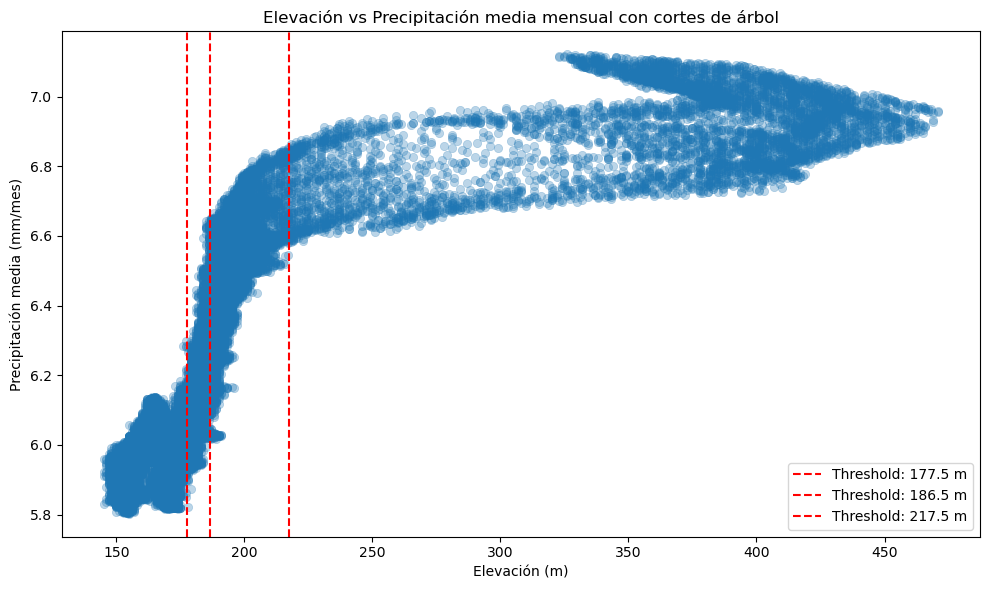

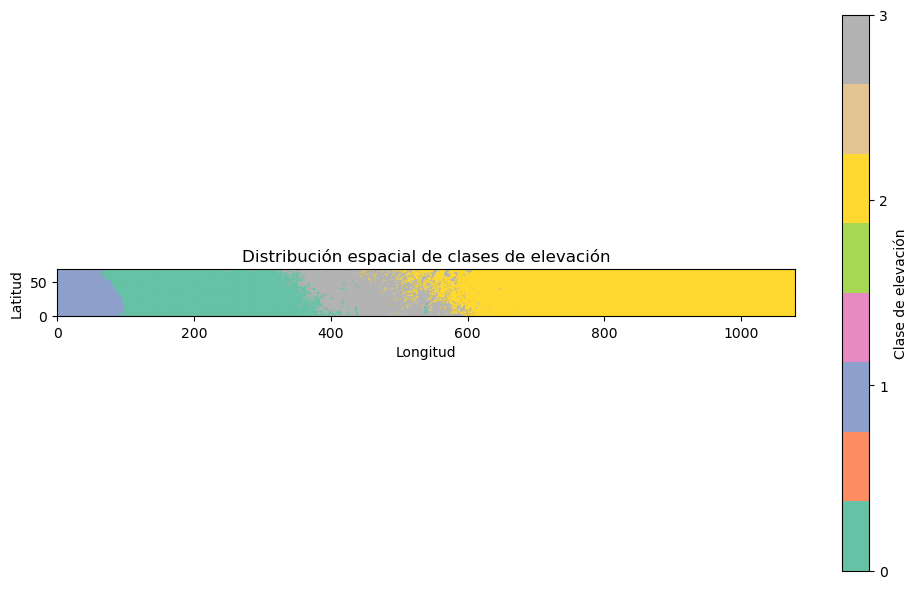

In [4]:
# Visualización de umbrales
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X.flatten(), y=y, alpha=0.3, edgecolor=None)
for th in thresholds:
    plt.axvline(th, color='red', linestyle='--', label=f'Threshold: {th:.1f} m')
plt.title("Elevación vs Precipitación media mensual con cortes de árbol")
plt.xlabel("Elevación (m)")
plt.ylabel("Precipitación media (mm/mes)")
plt.legend()
plt.tight_layout()
plt.show()

# Mapa de distribución por clase
plt.figure(figsize=(10, 6))
plt.title("Distribución espacial de clases de elevación")
plt.imshow(classes_map, origin='lower', cmap='Set2')
cbar = plt.colorbar(ticks=np.unique(classes_map))
cbar.set_label("Clase de elevación")
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.tight_layout()
plt.show()

In [5]:
# Preparar datos para entrenamiento
window = 6
X_data, y_data, groups = [], [], []
for i in range(window, precip.shape[0]):
    X_data.append(precip[i-window:i][..., np.newaxis])
    y_data.append(precip[i][..., np.newaxis])
    groups.append(i)
X_data = np.array(X_data)
y_data = np.array(y_data)
groups = np.array(groups)

In [6]:
# Modelo ConvLSTM
def create_convlstm_model(input_shape):
    inputs = tf.keras.Input(shape=input_shape)
    x = tf.keras.layers.ConvLSTM2D(32, (3,3), padding='same', return_sequences=True)(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ConvLSTM2D(16, (3,3), padding='same', return_sequences=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    outputs = tf.keras.layers.Conv2D(1, (3,3), activation='relu', padding='same')(x)
    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mse')
    return model

In [7]:
# Entrenamiento final y exportación
final_model = create_convlstm_model(X_data.shape[1:])
final_model.fit(X_data, y_data, epochs=5, batch_size=2, verbose=1)
preds = final_model.predict(X_data)
final_model.save("conv_lstm_model_final.h5")

Epoch 1/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - loss: 33.0971
Epoch 2/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - loss: 31.9573
Epoch 3/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - loss: 28.4230
Epoch 4/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - loss: 27.4578
Epoch 5/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - loss: 14.0525
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


In [8]:
# RMSE por clase de elevación
for cls in np.unique(classes_map):
    mask = (classes_map == cls)
    errors = []
    for t in range(preds.shape[0]):
        y_true = y_data[t][mask]
        y_pred = preds[t][mask]
        mse = mean_squared_error(y_true, y_pred)
        errors.append(np.sqrt(mse))
    print(f"Clase de elevación {cls}: RMSE = {np.mean(errors):.3f} mm")

Clase de elevación 0: RMSE = 6.402 mm
Clase de elevación 1: RMSE = 6.736 mm
Clase de elevación 2: RMSE = 5.967 mm
Clase de elevación 3: RMSE = 6.075 mm


In [9]:
# Exportar predicciones
pred_xr = xr.DataArray(preds, dims=("time", "latitude", "longitude", "channel"),
                       coords={"time": ds.time[window:], "latitude": ds.latitude, "longitude": ds.longitude})
pred_xr = pred_xr.squeeze("channel")
pred_xr.name = "predicted_precipitation"
pred_xr.to_netcdf("predicted_precip_12months.nc")

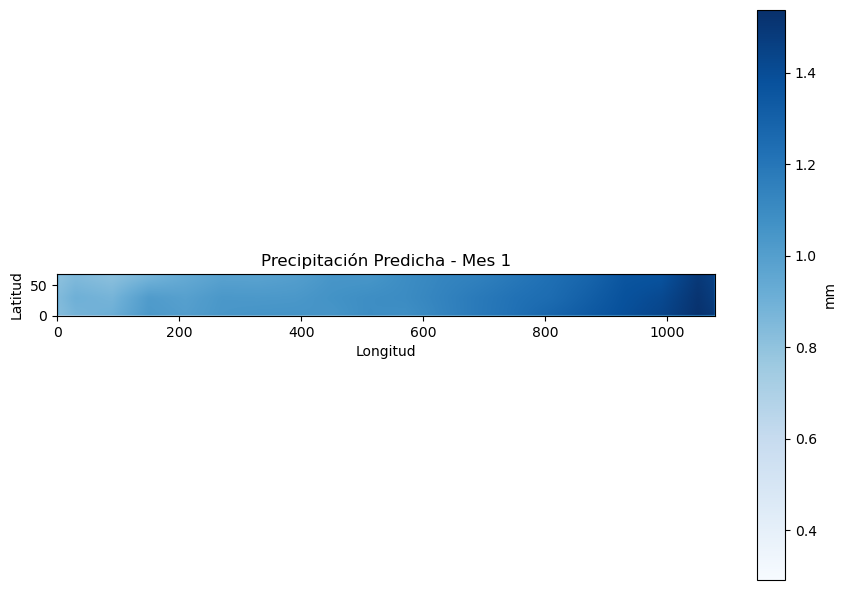

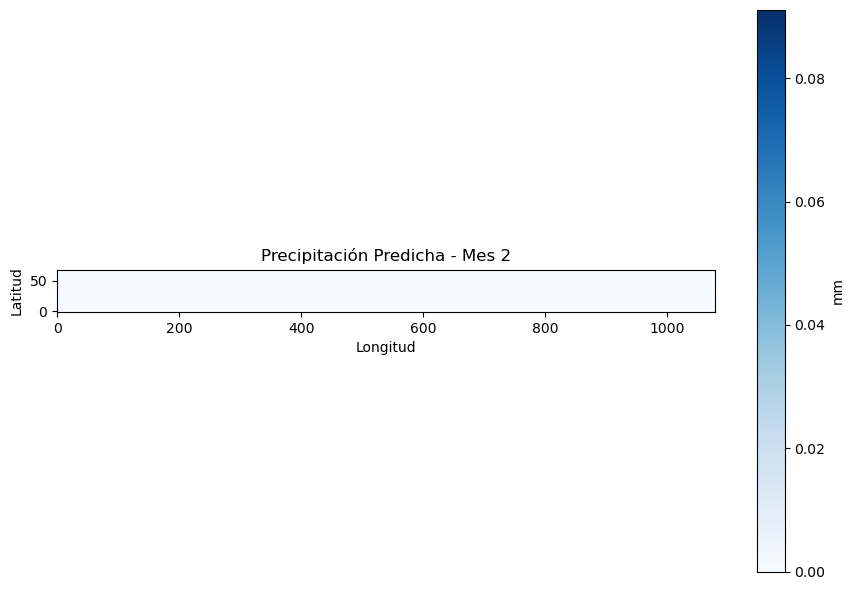

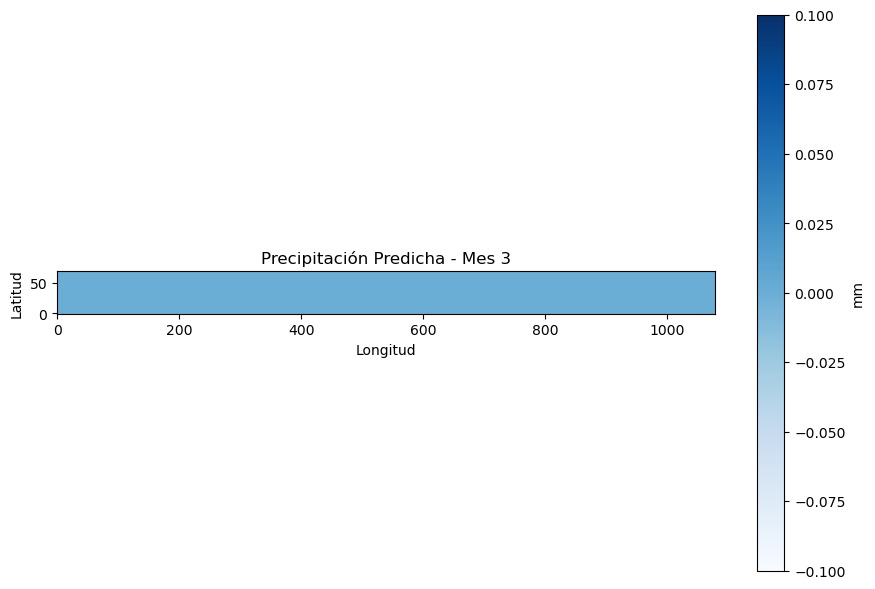

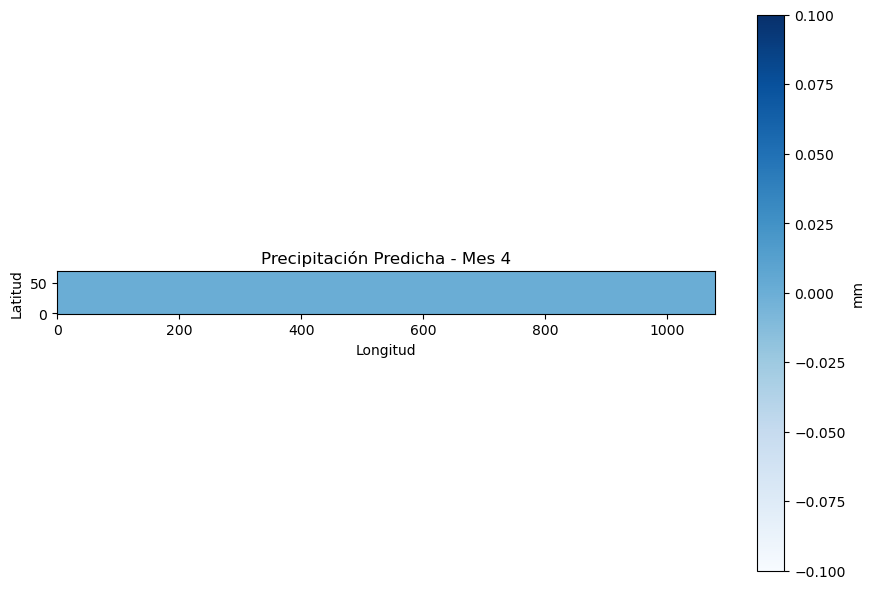

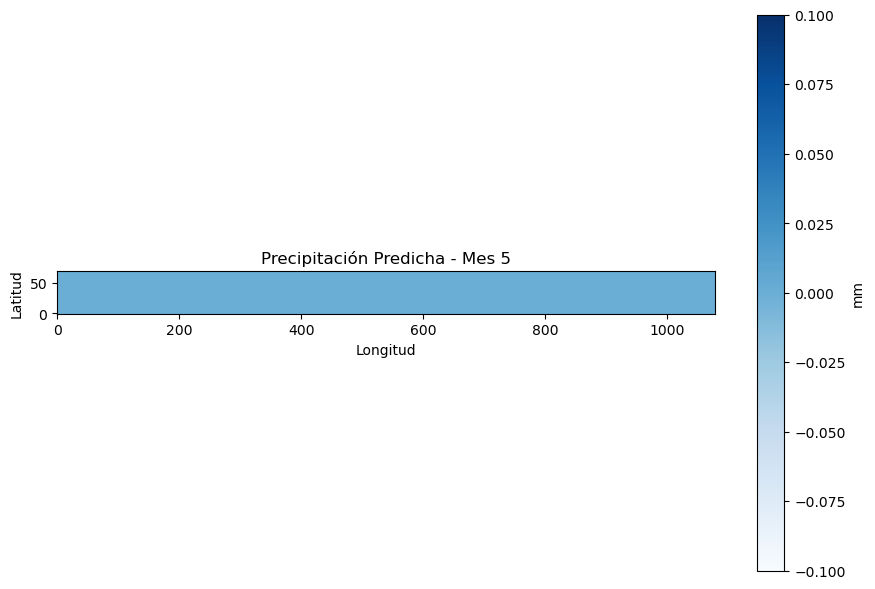

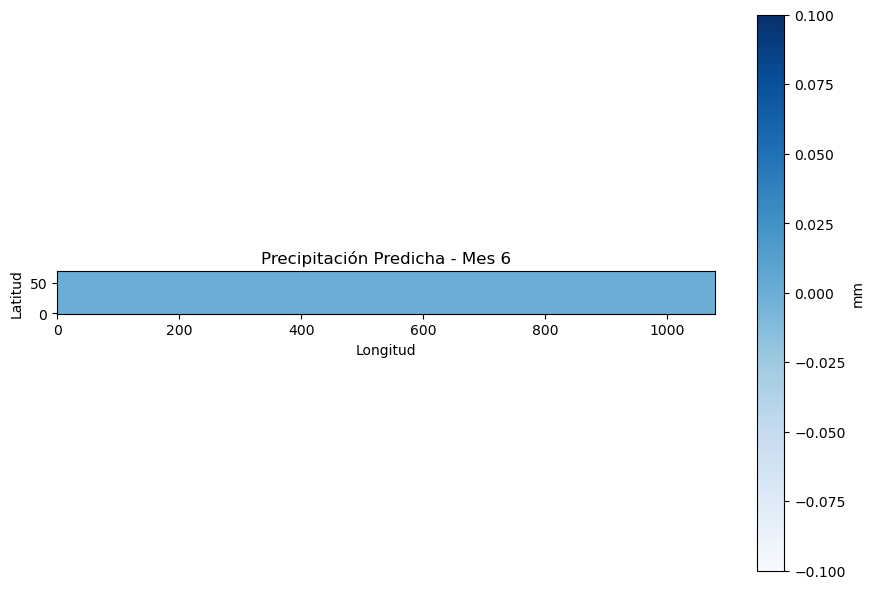

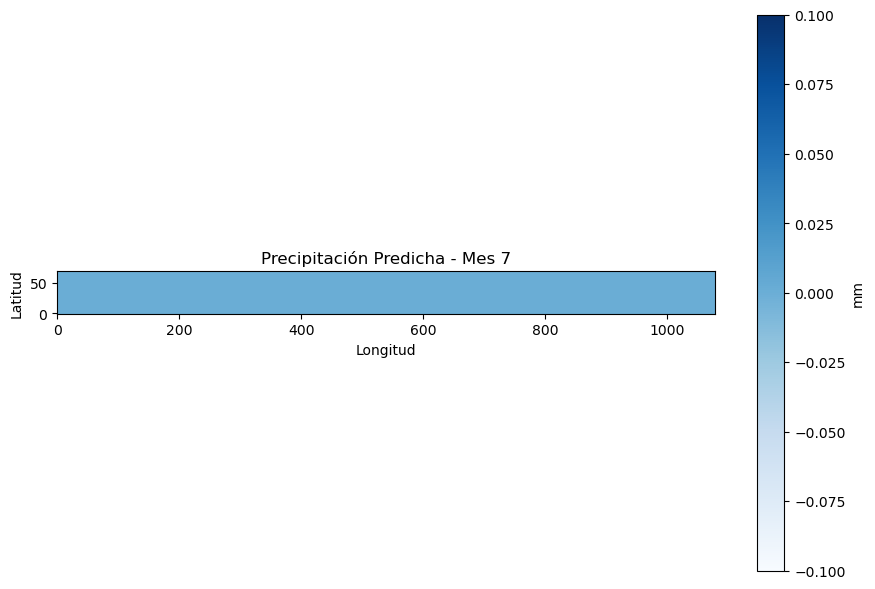

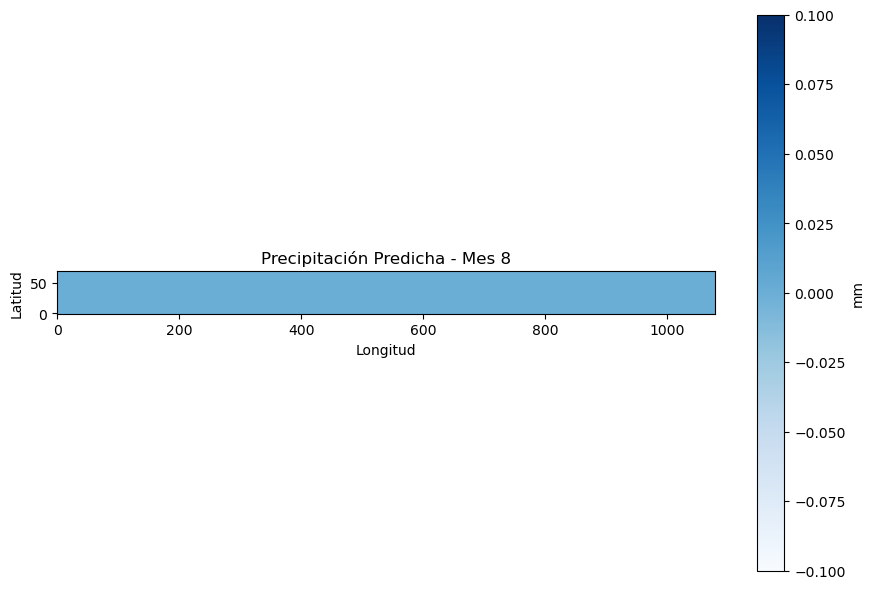

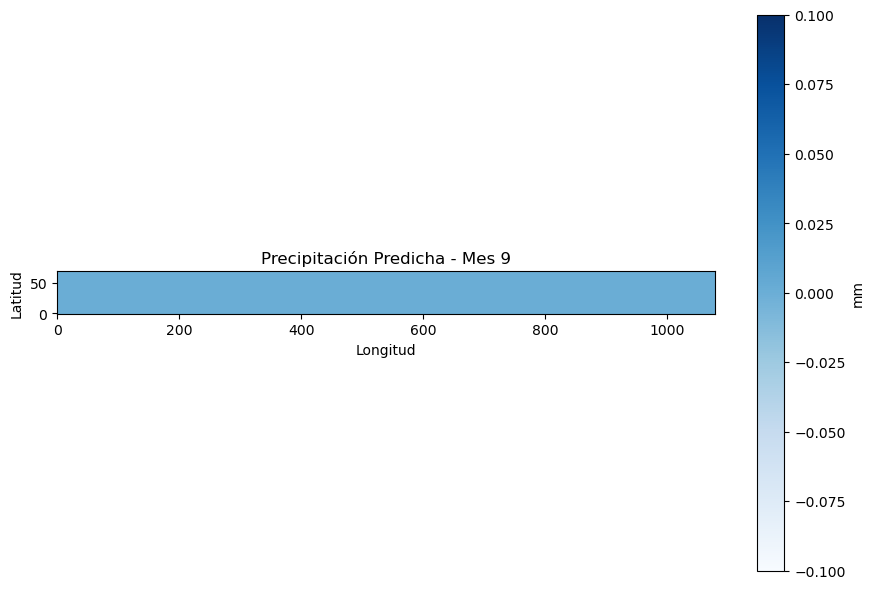

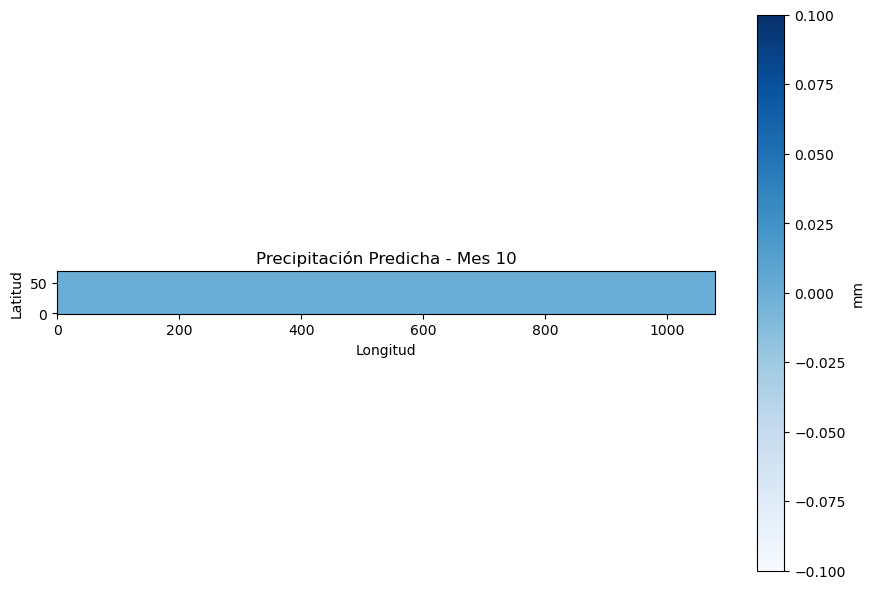

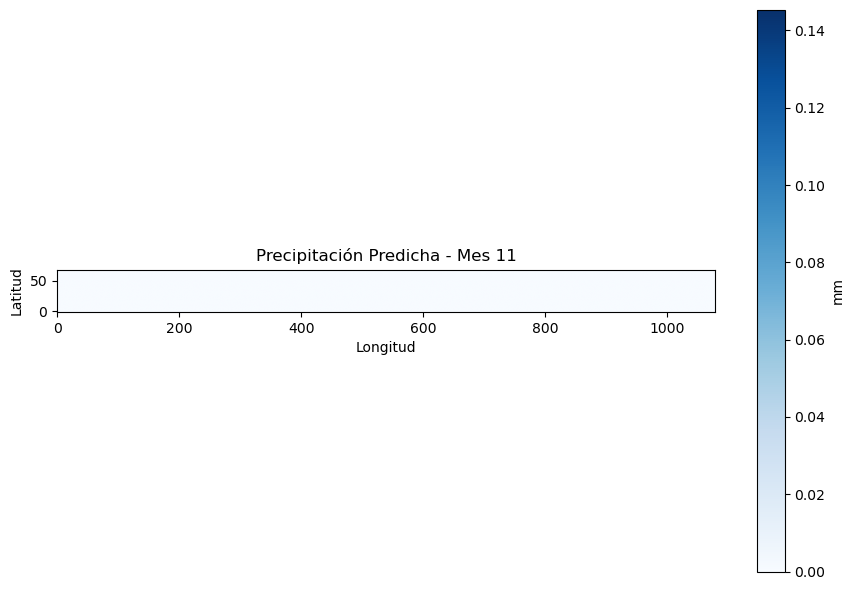

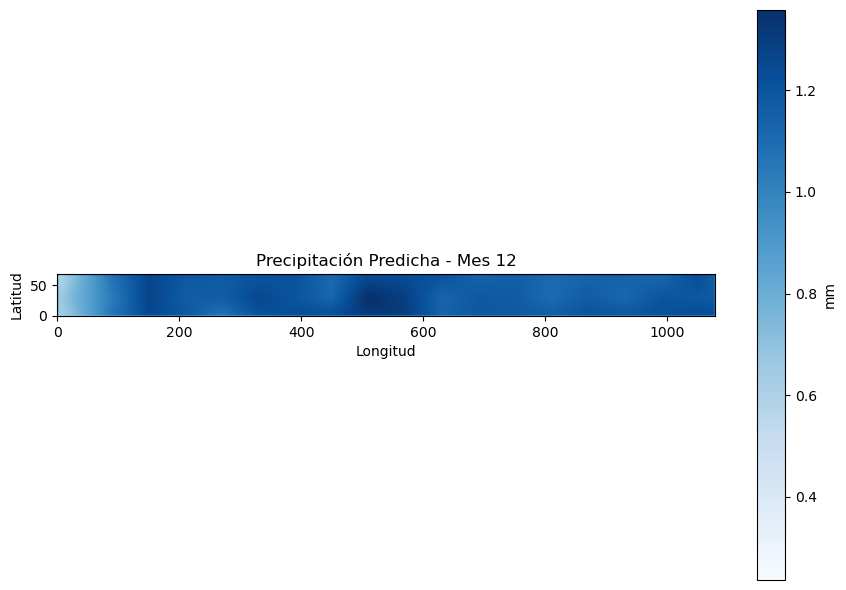

In [10]:
# Mapas mensuales de precipitación
for t in range(min(12, preds.shape[0])):
    plt.figure(figsize=(9,6))
    plt.title(f"Precipitación Predicha - Mes {t+1}")
    plt.imshow(preds[t].squeeze(), cmap='Blues', origin='lower')
    plt.colorbar(label='mm')
    plt.xlabel('Longitud')
    plt.ylabel('Latitud')
    plt.tight_layout()
    plt.show()

# 🔁 Comparación: Modelo sin elevación vs Modelo con elevación y segmentación
Se entrena un segundo modelo ConvLSTM **sin considerar elevación ni segmentación**, para compararlo con el modelo que sí incorpora estos factores.

In [ ]:
# Modelo sin elevación (baseline)
baseline_model = create_convlstm_model(X_data.shape[1:])
baseline_model.fit(X_data, y_data, epochs=5, batch_size=2, verbose=1)
preds_baseline = baseline_model.predict(X_data)
baseline_model.save("conv_lstm_model_baseline.h5")

Epoch 1/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - loss: 40.8546
Epoch 2/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - loss: 33.4866
Epoch 3/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - loss: 28.6824
Epoch 4/5
8/9 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step - loss: 20.8109

In [ ]:
from sklearn.metrics import mean_absolute_error, r2_score

def mape(y_true, y_pred):
    """Mean Absolute Percentage Error"""
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def nse(y_true, y_pred):
    """Nash-Sutcliffe Efficiency"""
    numerator = np.sum((y_true - y_pred) ** 2)
    denominator = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - (numerator / denominator)

def evaluate_model(y_true_all, y_pred_all):
    mask = ~np.isnan(y_true_all) & ~np.isnan(y_pred_all)
    y_true = y_true_all[mask]
    y_pred = y_pred_all[mask]
    return {
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAE': mean_absolute_error(y_true, y_pred),
        'MAPE (%)': mape(y_true, y_pred),
        'R²': r2_score(y_true, y_pred),
        'r (Pearson)': np.corrcoef(y_true, y_pred)[0, 1],
        'NSE': nse(y_true, y_pred)
    }

In [ ]:
# Evaluar modelos
metrics_con = evaluate_model(y_data, preds)
metrics_sin = evaluate_model(y_data, preds_baseline)
metrics_con, metrics_sin

({'RMSE': 7.087320110857119,
  'MAE': 6.1600565910339355,
  'MAPE (%)': 98.85735511779785,
  'R²': -2.7935478687286377,
  'r (Pearson)': 0.41531267015685236,
  'NSE': -2.7935478687286377},
 {'RMSE': 6.601021323509547,
  'MAE': 5.633773326873779,
  'MAPE (%)': 89.1182005405426,
  'R²': -2.2908167839050293,
  'r (Pearson)': 0.3596689021081626,
  'NSE': -2.2908167839050293})

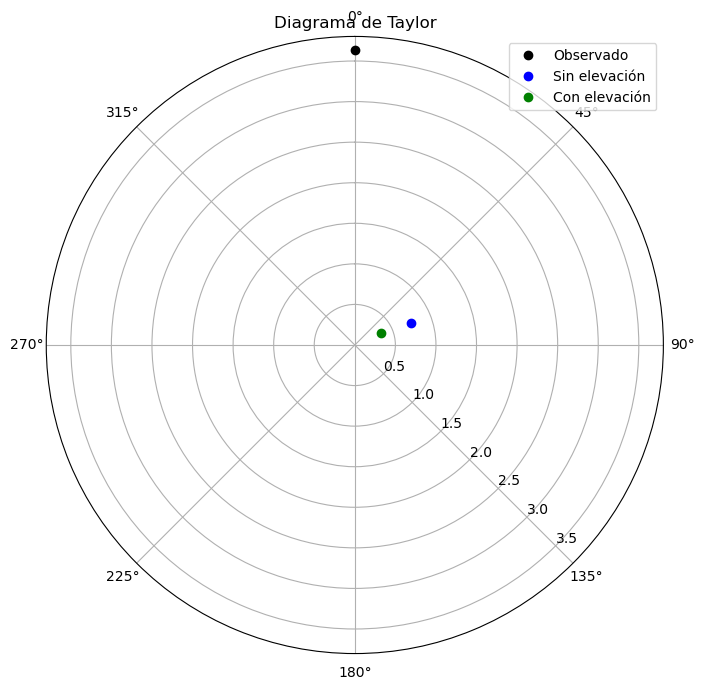

In [ ]:
# Diagrama de Taylor
def corr_to_angle(r): return np.arccos(r)
std_con = np.std(preds[~np.isnan(y_data)])
std_sin = np.std(preds_baseline[~np.isnan(y_data)])
std_ref = np.std(y_data[~np.isnan(y_data)])
corr_con = metrics_con['r (Pearson)']
corr_sin = metrics_sin['r (Pearson)']
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8, 7))
ax = fig.add_subplot(111, polar=True)
ax.plot([0], [std_ref], 'ko', label='Observado')
ax.plot(corr_to_angle(corr_sin), std_sin, 'bo', label='Sin elevación')
ax.plot(corr_to_angle(corr_con), std_con, 'go', label='Con elevación')
ax.set_theta_direction(-1)
ax.set_theta_zero_location('N')
ax.set_rlabel_position(135)
ax.set_title("Diagrama de Taylor")
ax.grid(True)
ax.legend(loc='upper right')
plt.tight_layout()
plt.show()

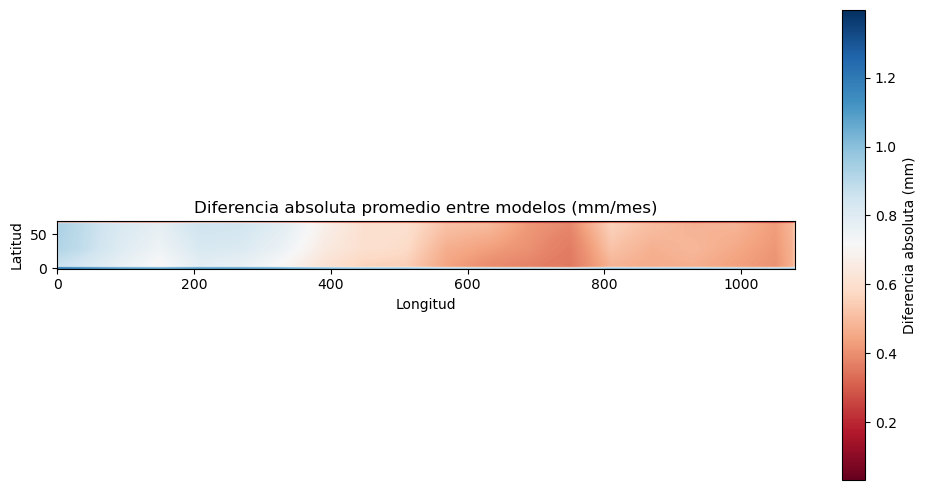

In [ ]:
# Mapa de diferencias absolutas entre modelos
diff_map = np.nanmean(np.abs(preds - preds_baseline), axis=0)
plt.figure(figsize=(10, 5))
plt.title("Diferencia absoluta promedio entre modelos (mm/mes)")
plt.imshow(diff_map, cmap='RdBu', origin='lower')
plt.colorbar(label='Diferencia absoluta (mm)')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.tight_layout()
plt.show()